In [1]:
from demohelpers import *

import numpy as np
import matplotlib.pyplot as plt
from trustyai.model import Model, feature, output, feature_domain
import pandas as pd
from sklearn.metrics import confusion_matrix
import shutil
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as tts
from skl2onnx import convert_sklearn
import xgboost
import os

plt.style.use('https://raw.githubusercontent.com/RobGeada/stylelibs/main/material_rh.mplstyle')

%load_ext autoreload
%autoreload 2

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


ImportError: cannot import name 'pinv2' from 'scipy.linalg' (/usr/local/lib/python3.10/site-packages/scipy/linalg/__init__.py)

# Load Data

In [8]:
def get_xy(df):
    return df[[x for x in list(df) if x not in [outcome, "Prediction", "Prediction_Unbiased"]]], df[outcome]

In [9]:
np.random.seed(0)
data = get_loan_data()
feature_names = [x for x in list(data) if x!="Default?"]
outcome = "Default?"
favorable = 0

/Users/rob/Documents/RedHat/trustyai-demo/trustyai-odh-notebook-demo/demohelpers.py:101: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop(


# Balance Data Artificially

In [10]:
def balance_data(df, n, field=outcome):
    ppos = df[(df["Male?"]==1) & (df[field]==favorable)]
    pneg = df[(df["Male?"]==1) & (df[field]!=favorable)]
    ptot =  len(ppos) + len(pneg)

    upos = df[(df["Male?"]==0) & (df[field]==favorable)]
    uneg = df[(df["Male?"]==0) & (df[field]!=favorable)]
    utot =  len(upos) + len(uneg)
    new_utot = n

    upos = upos.iloc[:int(len(ppos)*new_utot/ptot)]
    uneg = uneg.iloc[:int(len(pneg)*new_utot/ptot)]
    new_df = pd.concat([upos, uneg, ppos, pneg])
    np.random.seed(0)
    return new_df.sample(frac=1).reset_index(drop=True)
    
joint_data = balance_data(data, 3000) 

In [11]:
from trustyai.metrics.fairness.group import statistical_parity_difference, \
    disparate_impact_ratio, average_odds_difference, average_predictive_value_difference

def get_spd(df, field):
    df = df.drop([x for x in list(df) if x not in feature_names+[field]], axis=1)
    privileged = df[df['Male?'] == 1]
    unprivileged = df[df['Male?'] == 0]
    favorable_output = output(field, dtype="number", value=favorable)
    return statistical_parity_difference(privileged=privileged,
                                          unprivileged=unprivileged,
                                          favorable=[favorable_output])

get_spd(joint_data, outcome)

-0.00016470412693858627

# Unfairly Split Training Data

In [12]:
predicate = 'Days Old'
test_examples_indexer = (joint_data["Male?"]==0) & (joint_data["Days Old"]>15000) & (joint_data[outcome]==favorable)
raw_test_examples = joint_data[test_examples_indexer.values]
all_train_examples = joint_data[~test_examples_indexer.values]

slice_idx = int(len(all_train_examples)*.75)
train_examples = all_train_examples.iloc[:slice_idx]
train_examples = balance_data(train_examples, 500)
print(len(train_examples))
print(train_examples[['Male?',outcome]].value_counts())
print("Train SPD:",get_spd(train_examples, outcome))

print()
test_additions = all_train_examples[slice_idx:]
test_examples = pd.concat([raw_test_examples, test_additions])
print(len(test_examples))
print(test_examples[['Male?',outcome]].value_counts())
test_examples = test_examples.sample(frac=1).reset_index(drop=True)
print("Test SPD:", get_spd(test_examples, outcome))

In [74]:
np.random.seed(0)
unbiased_train, unbiased_test = tts(joint_data, test_size=.1)
ub_train = unbiased_train.copy()
ub_test = unbiased_test.copy()

fake_data = raw_test_examples.copy().sample(300)
print(len(fake_data))
fake_data["Default?"] = 1

#xgb_model = xgboost.XGBClassifier()
unbiased_model = RandomForestClassifier()
unbiased_model.fit(*get_xy(pd.concat([unbiased_train, fake_data])))

print('Train Accuracy: {:.2f}%'.format(unbiased_model.score(*get_xy(unbiased_train))*100))
ub_train["Prediction"] = unbiased_model.predict(get_xy(unbiased_train)[0])
ub_test["Prediction"] = unbiased_model.predict(get_xy(unbiased_test)[0])
train_examples["Prediction_Unbiased"] = unbiased_model.predict(get_xy(train_examples)[0])

# print(get_spd(ub_train, outcome))
# print(get_spd(ub_test, outcome))
# print(get_spd(ub_train, "Prediction"))
# print(get_spd(ub_test,"Prediction"))
print(get_spd(train_examples,"Prediction_Unbiased"))

300
Train Accuracy: 77.16%
-0.015463776668146245


In [75]:
np.random.seed(0)
#xgb_model = xgboost.XGBClassifier()
model = RandomForestClassifier()
model.fit(*get_xy(train_examples));
print('Train Accuracy: {:.2f}%'.format(model.score(*get_xy(train_examples))*100))
train_preds = model.predict(get_xy(train_examples)[0])
train_examples["Prediction"] = train_preds
train_examples = balance_data(train_examples, 500, "Prediction")
train_examples["Prediction_Unbiased"] = unbiased_model.predict(get_xy(train_examples)[0])

print("Biased Model SPD:", get_spd(train_examples, "Prediction"))
print("Unbiased Model SPD:", get_spd(train_examples, "Prediction_Unbiased"))

Train Accuracy: 78.65%
Biased Model SPD: 0.007916895309685423
Unbiased Model SPD: -0.015463776668146245


In [76]:
test_preds = model.predict(get_xy(test_examples)[0])
test_pred_probs = model.predict_proba(get_xy(test_examples)[0])
print('Test Accuracy: {:.2f}%'.format(model.score(*get_xy(test_examples))*100))
cmatrix = confusion_matrix(get_xy(test_examples)[1], test_preds)
print("\n  Correctly Predicted Defaulted:", cmatrix[0][0])
print("  Correctly Predicted Payed:    ", cmatrix[1][1])
print("Incorrectly Predicted Defaulted:", cmatrix[1][0])
print("Incorrectly Predicted Payed:    ", cmatrix[0][1])

Test Accuracy: 54.82%

  Correctly Predicted Defaulted: 870
  Correctly Predicted Payed:     1022
Incorrectly Predicted Defaulted: 299
Incorrectly Predicted Payed:     1260


In [77]:
raw_test_examples['Prediction'] = model.predict(get_xy(raw_test_examples)[0])
raw_test_examples['Prediction_Unbiased'] = unbiased_model.predict(get_xy(raw_test_examples)[0])

# print("Biased Model SPD:", get_spd(raw_test_examples, "Prediction"))
# print("Unbiased Model SPD:", get_spd(raw_test_examples, "Prediction_Unbiased"))

test_additions['Prediction'] = model.predict(get_xy(test_additions)[0])
test_additions['Prediction_Unbiased'] = unbiased_model.predict(get_xy(test_additions)[0])
combined_train_test = pd.concat([train_examples, test_additions, raw_test_examples])

/var/folders/0m/5lsb036n7l98p75674k5zcym0000gp/T/ipykernel_41168/1670456171.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_test_examples['Prediction'] = model.predict(get_xy(raw_test_examples)[0])
/var/folders/0m/5lsb036n7l98p75674k5zcym0000gp/T/ipykernel_41168/1670456171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_test_examples['Prediction_Unbiased'] = unbiased_model.predict(get_xy(raw_test_examples)[0])
/var/folders/0m/5lsb036n7l98p75674k5zcym0000gp/T/ipykernel_41168/1670456171.py:7: 

In [78]:
xs = []
ys = []
ys_cumul = []
ys_cumul_ub = []
batch_size = 250
batch_sizes = [len(train_examples)] + [len(train_examples)+i for i in range(batch_size, len(test_examples), batch_size)]
for idx, i in enumerate(batch_sizes):
    xs.append(idx)
    score = get_spd(combined_train_test.iloc[:i], "Prediction")
    score_ub = get_spd(combined_train_test.iloc[:i], "Prediction_Unbiased")
    print("{} {}: {:.3f} | {:.3f}".format(i, idx, float(score), float(score_ub)))
    ys_cumul.append(score)
    ys_cumul_ub.append(score_ub)

6243 0: 0.008 | -0.015
6493 1: -0.006 | -0.028
6743 2: -0.026 | -0.038
6993 3: -0.027 | -0.047
7243 4: -0.032 | -0.055
7493 5: -0.041 | -0.063
7743 6: -0.046 | -0.062
7993 7: -0.058 | -0.075
8243 8: -0.059 | -0.081
8493 9: -0.066 | -0.087
8743 10: -0.111 | -0.059
8993 11: -0.187 | 0.021
9243 12: -0.238 | 0.077
9493 13: -0.275 | 0.120


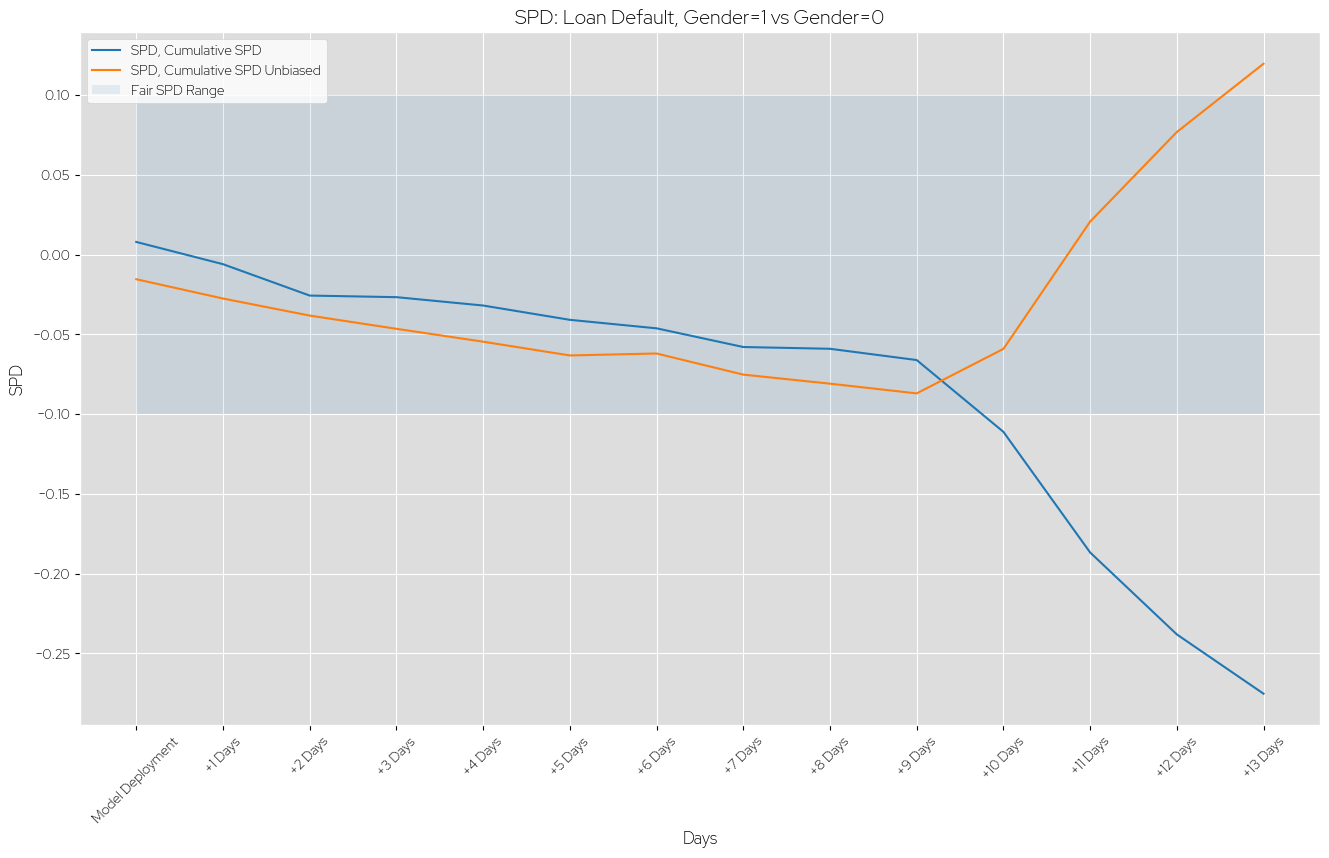

In [79]:
plt.plot(xs, ys_cumul, label="SPD, Cumulative SPD")
plt.plot(xs, ys_cumul_ub, label="SPD, Cumulative SPD Unbiased")
#plt.plot(xs, ys, label=f"SPD, Last {batch_size} Predictions")
plt.fill_between(xs, -.1, .1, alpha=0.1, label="Fair SPD Range")
plt.xlabel("Days")
plt.xticks(np.arange(len(xs)), ["Model Deployment"] + [f"+{x} Days" for x in xs[1:]], rotation=45)
plt.ylabel("SPD")
plt.title("SPD: Loan Default, Gender=1 vs Gender=0")
plt.legend()
plt.show()

[autoreload of pkg_resources failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/usr/local/Cellar/python@3.10/3.10.10/Frameworks/Python.framework/Versions/3.10/lib/python3.10/importlib/__init__.py", line 169, in reload
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/local/lib/python3.10/site-packages/pkg_resources/__init__.py", line 122, in <module>
    parse_version = packaging.version.Version
AttributeError: module 'pkg_resources._vendor.packaging' has no attribute 'version'
]
[autoreload of setuptools._distutils failed: Traceback (

ImportError: cannot import name 'pinv2' from 'scipy.linalg' (/usr/local/lib/python3.10/site-packages/scipy/linalg/__init__.py)

In [73]:
batch_start = 0
batch_pairs = []
for idx, batch in enumerate(batch_sizes):
    if idx==0:
        batch_pairs.append([0, batch])
    else:
        batch_pairs.append([batch_sizes[idx-1], batch])

In [49]:
def convert_to_json(datapoint):
    return """{{
  "inputs": [
    {{
      "name": "predict",
      "shape": [1, 11],
      "datatype": "FP64",
      "data": {}
    }}
  ]
}}""".format(list(datapoint.values))

for idx, batch in enumerate(batch_sizes):
    path = "/Users/rob/Documents/RedHat/StevenHuelsDemo/resources/data_json/"
    if idx==0:
        bname= "training_data"
    else:
        bname="batch_{}".format(str(idx).zfill(2))
    bpath = path+bname
    
    if bname not in os.listdir(path):
        os.mkdir(bpath)
    else:
        shutil.rmtree(bpath)
        os.mkdir(bpath)
        
    subslice = combined_train_test[batch_pairs[idx][0]:batch_pairs[idx][1]]
    subx = subslice[[x for x in list(subslice) if x not in [outcome, "Prediction"]]]
    print(bname, len(subx))

    for i in range(len(subx)):
        with open(bpath+"/{}.json".format(i), "w") as f:
            f.write(convert_to_json(subx.iloc[i]))

training_data 6243
batch_01 250
batch_02 250
batch_03 250
batch_04 250
batch_05 250
batch_06 250
batch_07 250
batch_08 250
batch_09 250
batch_10 250
batch_11 250
batch_12 250
batch_13 250


In [ ]:
subx

In [ ]:
b1 = subx.iloc[:500]
b1[b1.apply(lambda x: np.array_equal(x.values, [0.0,112500.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,20502.0,4450.0]), 1)]

In [ ]:
subx.iloc[:2].values

In [ ]:
for idx, batch in enumerate(batch_sizes):
    subslice = combined_train_test[:batch]
    
    subx = subslice[[x for x in list(subslice) if x not in [outcome, "Prediction"]]]
    suby = subslice["Prediction"]
    subx.to_csv(f"biased_loan_data/input_batches/batch{idx}.csv", index=False)
    suby.to_csv(f"biased_loan_data/output_batches/batch{idx}.csv", index=False)

In [ ]:
# for idx, i in enumerate(batch_sizes):
#     xs.append(idx)
#     df = pd.read_csv(f"biased_loan_data/batches/batch{idx}.csv")
#     score = get_spd(df, "Prediction")
#     print(i, idx, score)
#     ys_cumul.append(score)

In [ ]:
for idx, batch in enumerate(batch_sizes):
    subslice = combined_train_test[:batch]
        

In [ ]:
import joblib
joblib.dump(model, "loan_model.joblib")

In [ ]:
import pickle
with open("loan_model.sav", "wb") as f:
    pickle.dump(model, f)